In [1]:
import cv2
import csv
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pylab as pl
from skimage.filters import gaussian
from scipy import spatial
from sklearn.neighbors import KDTree
import bobsegutils as bsu
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave

Populating the interactive namespace from numpy and matplotlib


In [2]:
image_path = '/Users/prakash/Desktop/BobSegMarkData/2018-05-01_fromMark/MAX_C1-20180501_mNG-NMY-2_mSc-PH_01-01_Myosin.tif'
src_img = imread(image_path)
img_size = src_img.shape
row_size = range(0,img_size[1])
col_size = range(0,img_size[2])
print(img_size)

(61, 836, 628)


### Non-Smooth Warping/Flow Estimation

In [3]:
with open('/Users/prakash/Desktop/MarkGT/Tracks_with_uncertainty_radius.csv', 'r') as f:
    reader = csv.reader(f)
    uncertainty_radius_list_full = list(reader)
uncertainty_radius_list_full = uncertainty_radius_list_full[1:]
uncertainty_radius_list_full=np.array(uncertainty_radius_list_full,integer)
uncertainty_radius_list_full = [item for sublist in uncertainty_radius_list_full for item in sublist]
# print(uncertainty_radius_list_full)

In [4]:
uncertainty_radius_list_full = np.array(uncertainty_radius_list_full)
zero_uncertainty_index = np.where(uncertainty_radius_list_full == 0)[0]
nonzero_uncertainty_index = np.where(uncertainty_radius_list_full != 0)[0]

In [5]:
### Reading only certain indices (with uncertainty readius = 0) for warping

with open('/Users/prakash/Desktop/MarkGT/Choices_Structured.csv') as sd:
    source_reader=csv.reader(sd)
    next(source_reader)
    certain_source_rows=[row for idx, row in enumerate(source_reader) if idx in zero_uncertainty_index]
    uncertain_source_rows = [row for idx, row in enumerate(source_reader) if idx in nonzero_uncertainty_index]

with open('/Users/prakash/Desktop/MarkGT/Tracks_Structured.csv') as td:
    target_reader=csv.reader(td)
    next(target_reader)
    certain_target_rows=[row for idx, row in enumerate(target_reader) if idx in zero_uncertainty_index]
    uncertain_target_rows=[row for idx, row in enumerate(target_reader) if idx in nonzero_uncertainty_index]

In [6]:
### Reading only uncercertain indices (with uncertainty readius !=0) for validation of warped flow

with open('/Users/prakash/Desktop/MarkGT/Choices_Structured.csv') as sd:
    source_reader=csv.reader(sd)
    next(source_reader)
    uncertain_source_rows = [row for idx, row in enumerate(source_reader) if idx in nonzero_uncertainty_index]

with open('/Users/prakash/Desktop/MarkGT/Tracks_Structured.csv') as td:
    target_reader=csv.reader(td)
    next(target_reader)
    uncertain_target_rows=[row for idx, row in enumerate(target_reader) if idx in nonzero_uncertainty_index]

with open('/Users/prakash/Desktop/MarkGT/Tracks_with_uncertainty_radius.csv') as fd:
    uncertainty_radius_reader=csv.reader(fd)
    next(uncertainty_radius_reader)
    uncertain_radius_rows=[row for idx, row in enumerate(uncertainty_radius_reader) if idx in nonzero_uncertainty_index]

In [7]:
certain_sshape = np.array(certain_source_rows,float)
certain_tshape = np.array(certain_target_rows, float)

uncertain_sshape = np.array(uncertain_source_rows, float)
uncertain_tshape = np.array(uncertain_target_rows, float)
uncertain_radius_list = np.array(uncertain_radius_rows, float)

In [8]:
certain_sshape = [tuple(l) for l in certain_sshape]
certain_tshape = [tuple(m) for m in certain_tshape]
certain_source = []
certain_target = []
certain_source.append(certain_sshape)
certain_target.append(certain_tshape)

uncertain_sshape = [tuple(l) for l in uncertain_sshape]
uncertain_tshape = [tuple(m) for m in uncertain_tshape]
uncertain_source = []
uncertain_target = []
uncertain_source.append(uncertain_sshape)
uncertain_target.append(uncertain_tshape)

In [9]:
filename = '/Users/prakash/Desktop/BobSegMarkData/2018-05-01_fromMark/MAX_C1-20180501_mNG-NMY-2_mSc-PH_01-01_Myosin.tif'
myosin_channel = imread(filename)
print('Shape of stack:', myosin_channel.shape)
sigma = [0.,2.,2.]
myosin_channel_smooth = gaussian(myosin_channel,sigma)

Shape of stack: (61, 836, 628)


In [10]:
flows = bsu.compute_flow( myosin_channel)
flow_x, flow_y = bsu.split_flow_components( flows )
avg_flow_x = bsu.flow_average(flow_x, 1)
avg_flow_y = bsu.flow_average(flow_y, 1)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

............................................................. ...done!


In [11]:
flow_y.shape

(61, 836, 628)

In [12]:
flow_points = []
for frame, points in enumerate(certain_source):
    print(frame)
    flow_points_per_frame = []
    for i in range(len(points)):
        position = bsu.update_pos(points[i], frame, avg_flow_x, avg_flow_y )
        flow_points_per_frame.append(position)
    flow_points.append(flow_points_per_frame)

0


In [13]:
starting_points_flat_list = [item for sublist in certain_source for item in sublist]
manual_track_points_flat_list = [item for sublist in certain_target for item in sublist]
flow_points_flat_list = [item for sublist in flow_points for item in sublist]

In [14]:
pixel_lag_X = []
pixel_lag_Y = []

for i in range(len(starting_points_flat_list)):
    r2_X = starting_points_flat_list[i][0]-flow_points_flat_list[i][0]
    r1_X = starting_points_flat_list[i][0]-manual_track_points_flat_list[i][0]
    position_offset_X = r2_X-r1_X
    pixel_lag_X.append(position_offset_X)
    
    r2_Y = starting_points_flat_list[i][1]-flow_points_flat_list[i][1]
    r1_Y = starting_points_flat_list[i][1]-manual_track_points_flat_list[i][1]
    position_offset_Y = r2_Y-r1_Y
    pixel_lag_Y.append(position_offset_Y)    

In [15]:
### KD Tree Implementation
for flow_row in range(0, flow_x.shape[1]):
    for flow_col in range(0, flow_x.shape[2]):
        pt = [flow_col, flow_row]  # <-- the point to find
        distance,neighbor_index = spatial.KDTree(starting_points_flat_list).query(pt)
        avg_flow_x[0][flow_row][flow_col] = avg_flow_x[0][flow_row][flow_col] + pixel_lag_X[neighbor_index]
        avg_flow_y[0][flow_row][flow_col] = avg_flow_y[0][flow_row][flow_col] + pixel_lag_Y[neighbor_index]

In [16]:
warped_flow_points = []
for frame, points in enumerate(uncertain_source):
    print(frame)
    warped_flow_points_per_frame = []
    for i in range(len(points)):
        warped_position = bsu.update_pos(points[i], frame, avg_flow_x, avg_flow_y )
        warped_flow_points_per_frame.append(warped_position)
    warped_flow_points.append(warped_flow_points_per_frame)
warped_flow_points_flat_list = [item for sublist in warped_flow_points for item in sublist]

# print(warped_flow_points_flat_list)

0


In [17]:
validation_query_point_list = uncertain_sshape
validation_result_point_list = uncertain_tshape

### Quantification

In [18]:
pixel_lag = []
relative_pixel_lag = []
count = 0
for i in range(len(warped_flow_points_flat_list)):
    if(bsu.euclid_dist(warped_flow_points_flat_list[i], validation_result_point_list[i])<= uncertain_radius_list[i]):
        
        position_offset = 0
        relative_position_offset = 0
        count = count +1
    else:
        r2 = bsu.euclid_dist(validation_query_point_list[i], warped_flow_points_flat_list[i])
        r1 = bsu.euclid_dist(validation_query_point_list[i], validation_result_point_list[i])
        position_offset = r2-r1
        relative_position_offset = abs(position_offset)/r1
        
    
    pixel_lag.append(position_offset)
    relative_pixel_lag.append(relative_position_offset*100)

/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in double_scalars


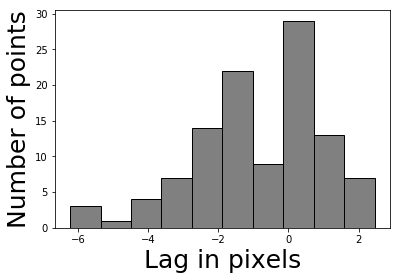

In [19]:
plt.hist(pixel_lag,histtype='bar', color='gray', ec='black')
plt.xlabel('Lag in pixels',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

In [20]:
print(np.median(pixel_lag))
print(np.median(relative_pixel_lag))
print(np.percentile(pixel_lag,75))
print(np.percentile(relative_pixel_lag,75))

-0.8021801710226291
40.10900855113145
0.07583250119310847
64.76370345059735


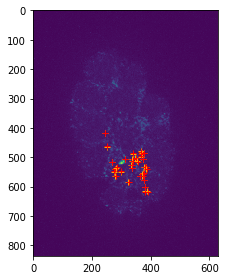

In [21]:
fig = plt.figure()
for element in range(len(starting_points_flat_list)):
#     plt.plot(starting_points_flat_list[element][0],starting_points_flat_list[element][1],'o',color='white') #Starting position
    plt.plot(manual_track_points_flat_list[element][0],manual_track_points_flat_list[element][1],'+',color='orange') #Updated position by flow computation
    plt.plot(flow_points_flat_list[element][0],flow_points_flat_list[element][1],'+',color='red') #Updated position by flow computation
    plt.imshow(myosin_channel[-1]) 
    fig.tight_layout()    